# A Monte Carlo Option Pricing Model Incorporating Non-Constant Volatility
Basic Setup of the Heston model: Expanding the Black-Scholes framework for when the constant volatility model is unsuitable. Letting both the underlying security's price, $S_t$ as well as the volatility, $V_t$, modelled by stochastic differential equations, two Wiener processes.

$dS_t = \mu S_tdt + \sqrt{V_t}S_tdW^1_t$


$dV_t = \kappa (\theta - V_t)dt + \sigma \sqrt{V_t}dW_t^2$

Realistically only have data on American Options so I'll have to make due with this. 
Problems:
* Esp. on dividend-paying stocks it causes problems -> Selecting non-dividend paying companies from S&P 500.
* Heston model because of its stochastic volatility has a greater pricing difference between European and American Call options compared to, say, Black-Scholes. The closed-form solution, even though I want to test divergence, but we're just gonna have to do it really scuffed

In [38]:
import numpy as np
from scipy.integrate import quad
import cmath
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [39]:
def get_ticker_data(ticker):
    # Dictionary to hold DataFrames for each ticker
    stock_data_dict = {}
    option_data_dict = {}

    stock_data = yf.Ticker(ticker)

    historical_data = stock_data.history(period='30d')
    
    stock_data_dict[ticker] = historical_data
    
    stock_data_df = pd.concat(stock_data_dict, names=['Ticker', 'Date']).reset_index(level=1, drop=False)
    
    print(stock_data.options)
    furthest_expiry = stock_data.options[14]    # apprx. a year out from observations, definitely a lot of room for improvement here.
    
    options = stock_data.option_chain(furthest_expiry)
    calls = options.calls
    selected_calls = calls[['strike', 'lastPrice']]  
    
    expiry_date = datetime.strptime(furthest_expiry, '%Y-%m-%d')
    today = datetime.today()
    time_to_expiry = (expiry_date - today).days
    
    selected_calls['Time to Expiry (days)'] = [time_to_expiry] * len(selected_calls)
    
    option_data_dict[ticker] = selected_calls.reset_index(drop=True)
    option_data_df = pd.concat(option_data_dict, names=['Ticker', 'Option']).reset_index(level=1, drop=True)
    # stock_data_df = pd.concat(stock_data_dict, names=['Ticker', 'Date']).reset_index(level=1, drop=False)
    
    return option_data_df, stock_data_df



In [43]:
ticker = "AMD"
option_data_df, stock_data_df = get_ticker_data(ticker)
option_data_df.to_csv(f"option_data_{ticker}.csv")
stock_data_df.to_csv(f"stock_data_{ticker}.csv")
option_data_df

('2023-09-01', '2023-09-08', '2023-09-15', '2023-09-22', '2023-09-29', '2023-10-06', '2023-10-20', '2023-11-17', '2023-12-15', '2024-01-19', '2024-02-16', '2024-03-15', '2024-04-19', '2024-06-21', '2024-09-20', '2025-01-17', '2025-06-20', '2025-12-19')


C:\Users\oscar\AppData\Local\Temp\ipykernel_4836\2685235747.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_calls['Time to Expiry (days)'] = [time_to_expiry] * len(selected_calls)


,strike,lastPrice,Time to Expiry (days)
Ticker,,,
AMD,30.0,77.17,388
AMD,35.0,71.97,388
AMD,40.0,67.26,388
AMD,45.0,63.85,388
AMD,50.0,56.82,388
AMD,55.0,54.51,388
AMD,60.0,49.15,388
AMD,65.0,44.80,388
AMD,70.0,40.80,388


In [53]:
def mc_paths(option_data_df, stock_data_df):
    S_0 = stock_data_df['Close'].iloc[-1]
    stock_data_df['Daily_Return'] = stock_data_df['Close'].pct_change()
    historical_volatility = np.std(stock_data_df['Daily_Return'].dropna()) * np.sqrt(252)  # Annualized
    r_f = 0.053 # Apprx. the short-term treasury rate, just the 3-month yield
    T = option_data_df["Time to Expiry (days)"][0]/365

    v_0_estimated = historical_volatility**2  
    theta_estimated = historical_volatility**2

    # 2. Mean Reversion Speed (kappa)
    # eh, we'll throw in a parameter like 1 as an educated guess
    kappa_estimated = 1.0

    # 3. Volatility of Volatility (sigma)
    # Calculating the rolling standard deviation of daily returns and then its standard deviation
    window_size = 21  # Approx. one trading month
    rolling_volatility = stock_data_df['Daily_Return'].rolling(window=window_size).std() * np.sqrt(252)  # Annualized
    sigma_estimated = np.std(rolling_volatility.dropna())

    # 4. Correlation Coefficient 
    daily_returns = stock_data_df['Daily_Return'].dropna()
    changes_in_volatility = rolling_volatility.diff().dropna()
    rho_estimated = np.corrcoef(daily_returns[-len(changes_in_volatility):], changes_in_volatility)[0, 1]
    timeStepsPerYear = 12  # monthly time steps
    iterations = 10000  # number of Monte Carlo paths
    timesteps = int(T * timeStepsPerYear)
    dt = 1 / timeStepsPerYear

    # Containers for St and Vt
    S_t = np.zeros((timesteps, iterations))
    V_t = np.zeros((timesteps, iterations))

    V_t[0, :] = v_0_estimated
    S_t[0, :] = S_0

    # Generate correlated Gaussians
    means = [0, 0]
    stdevs = [1, 1]
    covs = [[stdevs[0]**2, stdevs[0] * stdevs[1] * rho_estimated],
            [stdevs[0] * stdevs[1] * rho_estimated, stdevs[1]**2]]
    Z = np.random.multivariate_normal(means, covs, (iterations, timesteps)).T
    Z1 = Z[0]
    Z2 = Z[1]

    # Monte Carlo simulation using Euler's method for calculating SDE.
    for i in range(1, timesteps):
        # Update Vt using Z2
        V_t[i, :] = np.maximum(V_t[i - 1, :] +
                            kappa_estimated * (theta_estimated - V_t[i - 1, :]) * dt +
                            sigma_estimated * np.sqrt(V_t[i - 1, :] * dt) * Z2[i, :], 0)
        
        # Update St using the new Vt and Z1
        S_t[i, :] = S_t[i - 1, :] + r_f * S_t[i - 1, :] * dt + \
                    np.sqrt(V_t[i, :] * dt) * S_t[i - 1, :] * Z1[i, :]


    # Plotting paths
    plt.figure(figsize=(10, 6))
    for i in range(10):
        plt.plot(np.linspace(0, T, timesteps), S_t[:, i])

    unique_strike_prices = option_data_df['strike'].unique()
    mc_option_prices = []

    for K in unique_strike_prices:
        mc_option_price = np.mean(np.maximum(S_t[-1, :] - K, 0)) * np.exp(-r_f * T)
        mc_option_prices.append(mc_option_price)

    comparison_df = pd.DataFrame({
        'Strike Price': unique_strike_prices,
        'MC Option Price': mc_option_prices,
    })
    
    merged_comparison_df = pd.merge(comparison_df, option_data_df[['strike', 'lastPrice']].drop_duplicates(), 
                                    left_on='Strike Price', right_on='strike', how='inner')
    merged_comparison_df = merged_comparison_df.drop(columns=['strike'])
    merged_comparison_df.rename(columns={'lastPrice': 'Actual Option Price'}, inplace=True)
    return merged_comparison_df

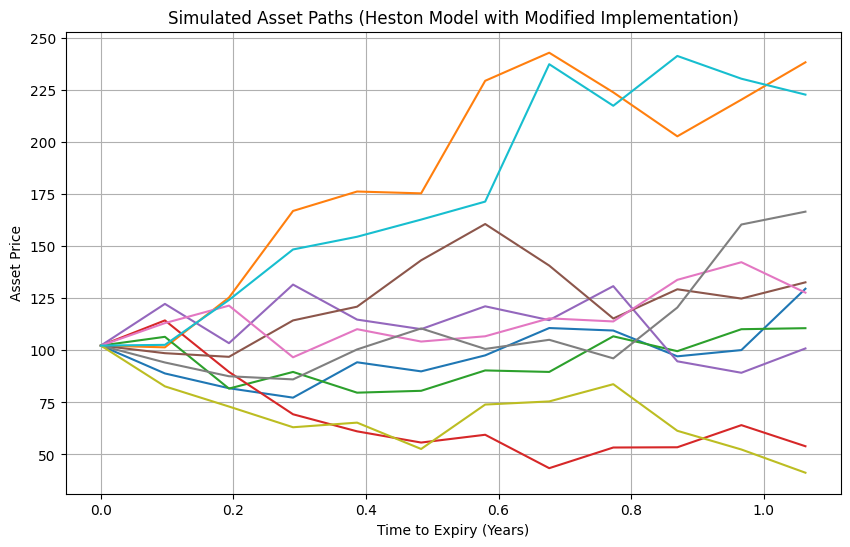

In [59]:
merged_comparison_df = mc_paths(option_data_df, stock_data_df)
plt.title('Simulated Asset Paths (Heston Model with Modified Implementation)')
plt.xlabel('Time to Expiry (Years)')
plt.ylabel('Asset Price')
plt.grid(True)
plt.show()

In [63]:
#visualizing the comparison between Monte Carlo and actual option prices
def plot_option_comparison(merged_comparison_df):
    plt.figure(figsize=(12, 8))
    plt.scatter(merged_comparison_df['Strike Price'], merged_comparison_df['MC Option Price'], label='Monte Carlo Prices', marker='o')
    plt.scatter(merged_comparison_df['Strike Price'], merged_comparison_df['Actual Option Price'], label='Actual Prices', marker='x')
    plt.xlabel('Strike Price')
    plt.ylabel('Option Price')
    plt.title('Comparison of Monte Carlo and Actual Option Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

In [61]:
def all(ticker):
    option_data_df, stock_data_df = get_ticker_data(ticker)
    option_data_df.to_csv(f"option_data_{ticker}.csv")
    stock_data_df.to_csv(f"stock_data_{ticker}.csv")
    merged_comparison_df = mc_paths(option_data_df, stock_data_df)
    plt.title('Simulated Asset Paths (Heston Model with Modified Implementation)')
    plt.xlabel('Time to Expiry (Years)')
    plt.ylabel('Asset Price')
    plt.grid(True)
    plt.show()
    plot_option_comparison(merged_comparison_df)


('2023-09-01', '2023-09-08', '2023-09-15', '2023-09-22', '2023-09-29', '2023-10-06', '2023-10-20', '2023-11-17', '2023-12-15', '2024-01-19', '2024-02-16', '2024-03-15', '2024-04-19', '2024-06-21', '2024-09-20', '2025-01-17', '2025-06-20', '2025-12-19')


C:\Users\oscar\AppData\Local\Temp\ipykernel_4836\2685235747.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_calls['Time to Expiry (days)'] = [time_to_expiry] * len(selected_calls)


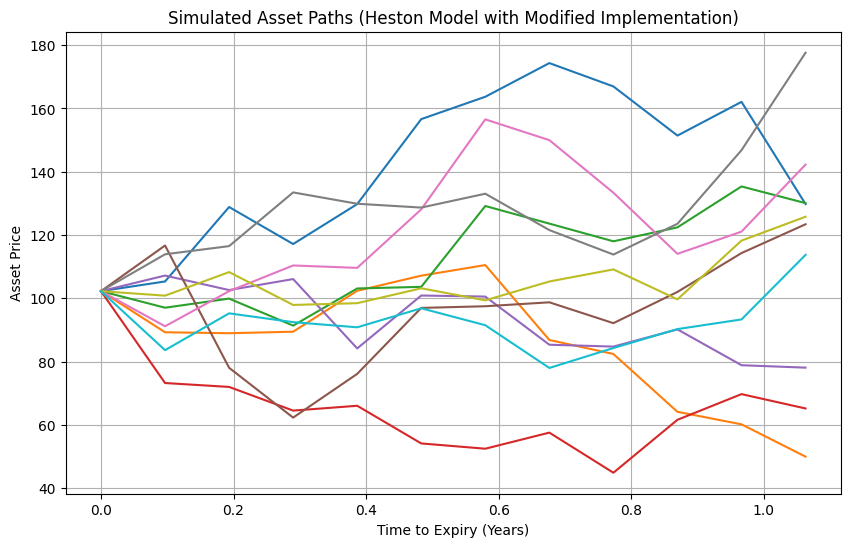

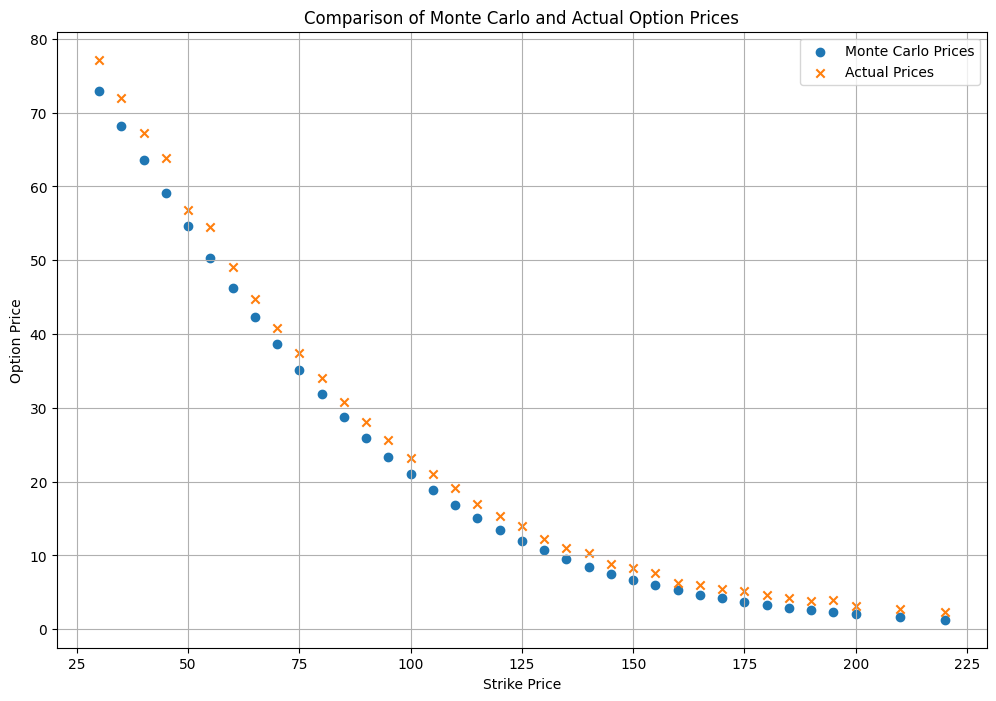

In [64]:
all("AMD")

('2023-09-01', '2023-09-08', '2023-09-15', '2023-09-22', '2023-09-29', '2023-10-06', '2023-10-20', '2023-11-17', '2023-12-15', '2024-01-19', '2024-02-16', '2024-03-15', '2024-06-21', '2024-09-20', '2025-01-17', '2025-06-20', '2025-09-19', '2025-12-19')


C:\Users\oscar\AppData\Local\Temp\ipykernel_4836\2685235747.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_calls['Time to Expiry (days)'] = [time_to_expiry] * len(selected_calls)


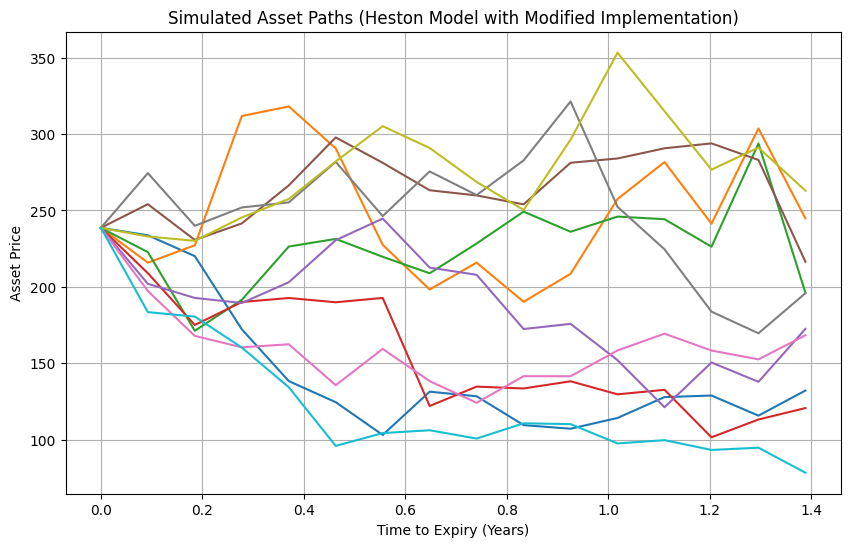

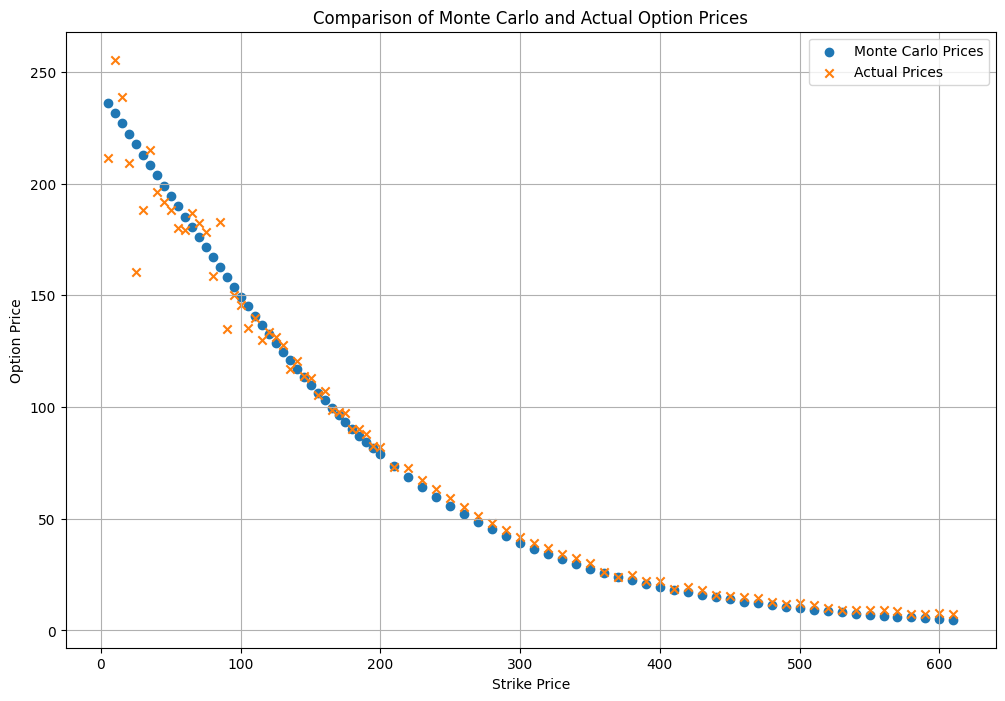

In [65]:
all("TSLA")

('2023-09-01', '2023-09-08', '2023-09-15', '2023-09-22', '2023-09-29', '2023-10-06', '2023-10-20', '2023-11-17', '2023-12-15', '2024-01-19', '2024-03-15', '2024-06-21', '2024-09-20', '2025-01-17', '2025-06-20', '2025-12-19')


C:\Users\oscar\AppData\Local\Temp\ipykernel_4836\2685235747.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_calls['Time to Expiry (days)'] = [time_to_expiry] * len(selected_calls)


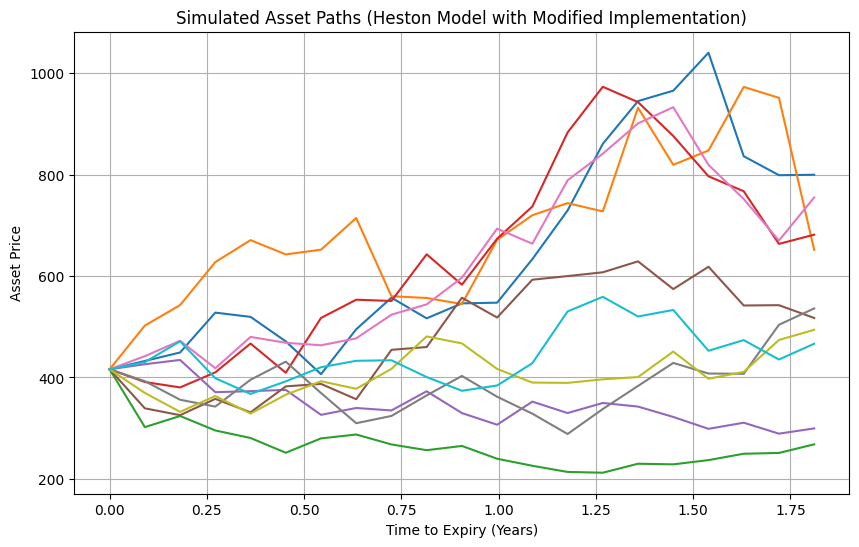

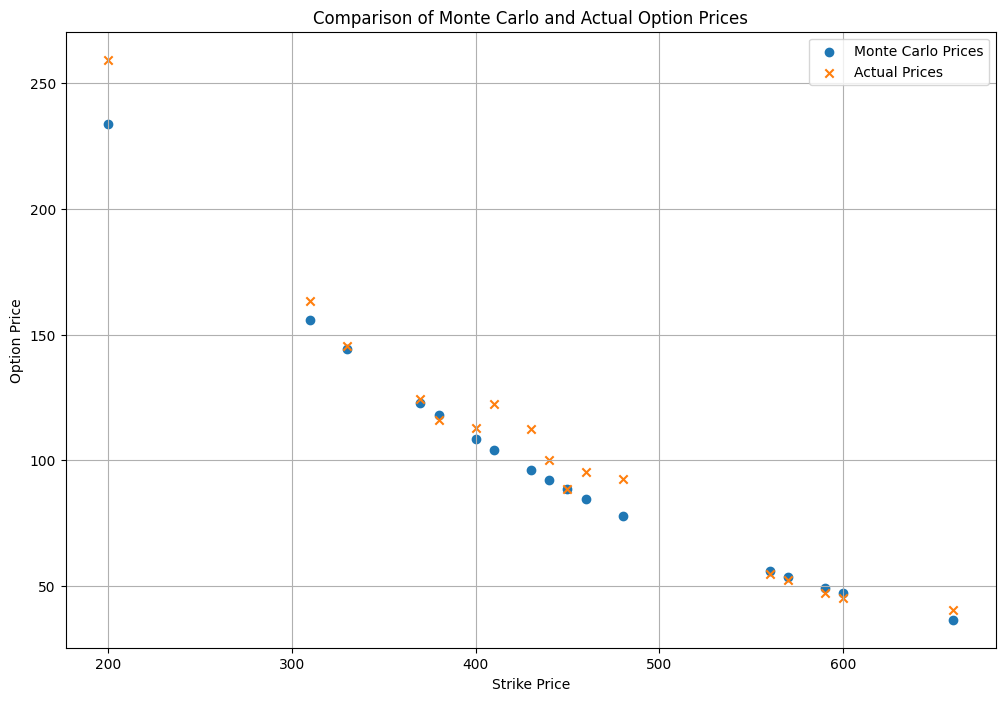

In [66]:
all("NFLX")

Integrating closed-form solution (even though we're working with American call options) just for the sake of comparison

In [ ]:
from scipy.integrate import quad
import cmath


In [70]:
def heston_cf(u, t, r, S_0, v_0, kappa, theta, sigma, rho):
    xi = sigma
    a = kappa * theta
    x = np.log(S_0)
    
    alpha = -u**2 / 2 - 1j * u / 2
    beta = kappa - rho * xi * 1j * u
    gamma = xi**2 / 2
    
    d = np.sqrt(beta**2 - 4 * alpha * gamma)
    rplus = (beta + d) / 2
    rminus = (beta - d) / 2
    
    g = rminus / rplus
    D = rminus * (1 - np.exp(-d * t)) / (1 - g * np.exp(-d * t))
    C = kappa * (rminus * t - 2 / xi**2 * np.log((1 - g * np.exp(-d * t)) / (1 - g)))
    
    cf = np.exp(C * a + D * v_0 + 1j * u * x)
    
    return cf

In [71]:
def heston_price(PutCall, S_0, K, T, r, v_0, kappa, theta, sigma, rho):
    integrand = lambda u: (np.exp(-1j * u * np.log(K)) * heston_cf(u - 1j * (PutCall == 'P'), T, r, S_0, v_0, kappa, theta, sigma, rho) / (1j * u * heston_cf(-1j * (PutCall == 'P'), T, r, S_0, v_0, kappa, theta, sigma, rho))).real

    integral = quad(integrand, 0, 100)[0]
    
    return np.exp(-r * T) * (S_0 * np.exp(r * T) * (1 - (PutCall == 'P')) - K * (PutCall == 'P') + integral / np.pi)

In [72]:
def heston_monte_carlo(S_0, K, T, r, v_0, kappa, theta, sigma, rho, timeStepsPerYear=12, iterations=10000):
    dt = 1 / timeStepsPerYear
    timesteps = int(T * timeStepsPerYear)

    S_t = np.zeros((timesteps, iterations))
    V_t = np.zeros((timesteps, iterations))

    S_t[0, :] = S_0
    V_t[0, :] = v_0

    means = [0, 0]
    stdevs = [1, 1]
    covs = [[stdevs[0]**2, stdevs[0] * stdevs[1] * rho],
            [stdevs[0] * stdevs[1] * rho, stdevs[1]**2]]
    Z = np.random.multivariate_normal(means, covs, (iterations, timesteps)).T
    Z1 = Z[0]
    Z2 = Z[1]

    for i in range(1, timesteps):
        V_t[i, :] = np.maximum(V_t[i - 1, :] + kappa * (theta - V_t[i - 1, :]) * dt + sigma * np.sqrt(V_t[i - 1, :] * dt) * Z2[i, :], 0)
        S_t[i, :] = S_t[i - 1, :] + r * S_t[i - 1, :] * dt + np.sqrt(V_t[i, :] * dt) * S_t[i - 1, :] * Z1[i, :]

    option_price_mc = np.mean(np.maximum(S_t[-1, :] - K, 0)) * np.exp(-r * T)
    
    return option_price_mc

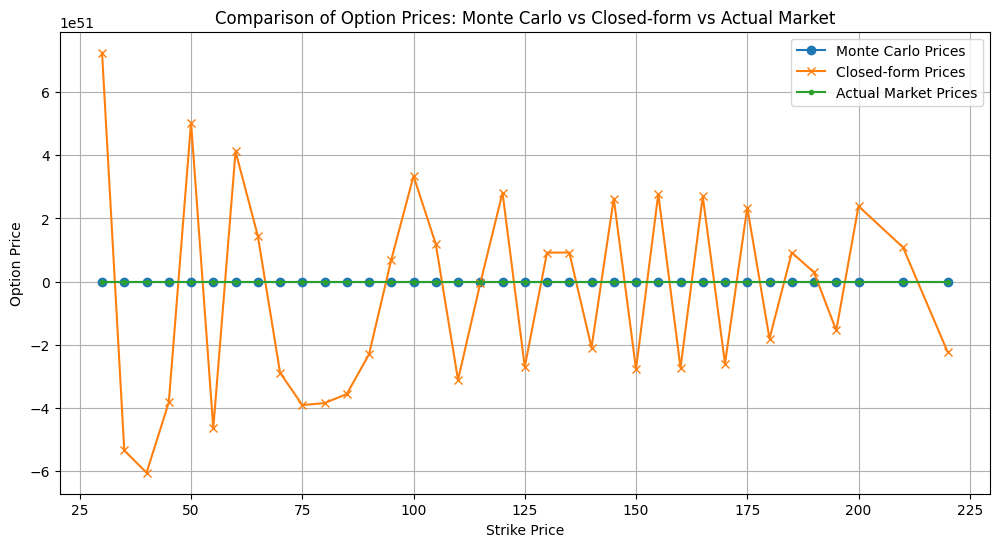

In [75]:
# Generate option prices using Monte Carlo and closed-form solution
strike_prices = option_data_df['strike'].unique()
mc_prices = []
cf_prices = []
S_0 = stock_data_df['Close'].iloc[-1]
stock_data_df['Daily_Return'] = stock_data_df['Close'].pct_change()
historical_volatility = np.std(stock_data_df['Daily_Return'].dropna()) * np.sqrt(252)  # Annualized
r_f = 0.053 # Apprx. the short-term treasury rate, just the 3-month yield
T = option_data_df["Time to Expiry (days)"][0]/365

v_0_estimated = historical_volatility**2  
theta_estimated = historical_volatility**2

# 2. Mean Reversion Speed (kappa)
# eh, we'll throw in a parameter like 1 as an educated guess
kappa_estimated = 1.0

# 3. Volatility of Volatility (sigma)
# Calculating the rolling standard deviation of daily returns and then its standard deviation
window_size = 21  # Approx. one trading month
rolling_volatility = stock_data_df['Daily_Return'].rolling(window=window_size).std() * np.sqrt(252)  # Annualized
sigma_estimated = np.std(rolling_volatility.dropna())

# 4. Correlation Coefficient 
daily_returns = stock_data_df['Daily_Return'].dropna()
changes_in_volatility = rolling_volatility.diff().dropna()
rho_estimated = np.corrcoef(daily_returns[-len(changes_in_volatility):], changes_in_volatility)[0, 1]
timeStepsPerYear = 12  # monthly time steps
iterations = 10000  # number of Monte Carlo paths
timesteps = int(T * timeStepsPerYear)
dt = 1 / timeStepsPerYear


for K in strike_prices:
    mc_price = heston_monte_carlo(S_0, K, T, r_f, v_0_estimated, kappa_estimated, theta_estimated, sigma_estimated, rho_estimated)
    cf_price = heston_price('C', S_0, K, T, r_f, v_0_estimated, kappa_estimated, theta_estimated, sigma_estimated, rho_estimated)
    mc_prices.append(mc_price)
    cf_prices.append(cf_price)

# Extract actual market prices for the same strike prices
actual_prices = option_data_df.groupby('strike')['lastPrice'].mean().values

# Generate the comparison plot
plt.figure(figsize=(12, 6))
plt.plot(strike_prices, mc_prices, label='Monte Carlo Prices', marker='o')
plt.plot(strike_prices, cf_prices, label='Closed-form Prices', marker='x')
plt.plot(strike_prices, actual_prices, label='Actual Market Prices', marker='.')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Comparison of Option Prices: Monte Carlo vs Closed-form vs Actual Market')
plt.legend()
plt.grid(True)
plt.show()